<a href="https://colab.research.google.com/github/Parixxx21/ECE219-Project2/blob/sia/219pset2part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Q13

Even if a VGG network is trained on a dataset with different classes such as ImageNet, it mainly learns general visual features rather than class-specific information. The early layers capture basic patterns like edges and textures, while deeper layers learn more complex shapes and object parts. Since these features are common across most natural images, they are still useful for distinguishing new classes when VGG is used as a feature extractor.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

## Q14

The helper code extracts features using a pretrained VGG-16 model. Each flower image is resized and normalized, then passed through the VGG-16 network. Instead of using the final classification layer, the code takes the output from the first fully connected layer, which produces a 4096-dimensional feature vector for each image. These vectors represent high-level visual patterns in the images. The features and their labels are saved to disk so they can be reused later without running the network again.

In [2]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

/tmp/ipython-input-2130011012.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  file.extractall('./')


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 148MB/s]
100%|██████████| 58/58 [00:34<00:00,  1.68it/s]


## Q15
224 * 224 *3 =150528 pixel values.
4096-dimensional feature vector.

## Q16
The VGG features are dense, meaning most values in the 4096-dimensional vector are non-zero because they come from neural network activations. This is different from TF-IDF features, where most values are zero since each document only contains a small number of words. In short, VGG features capture visual patterns with many active values, while TF-IDF represents text by counting which words appear.

## Q17

f_all: (3670, 4096) y_all: (3670,)


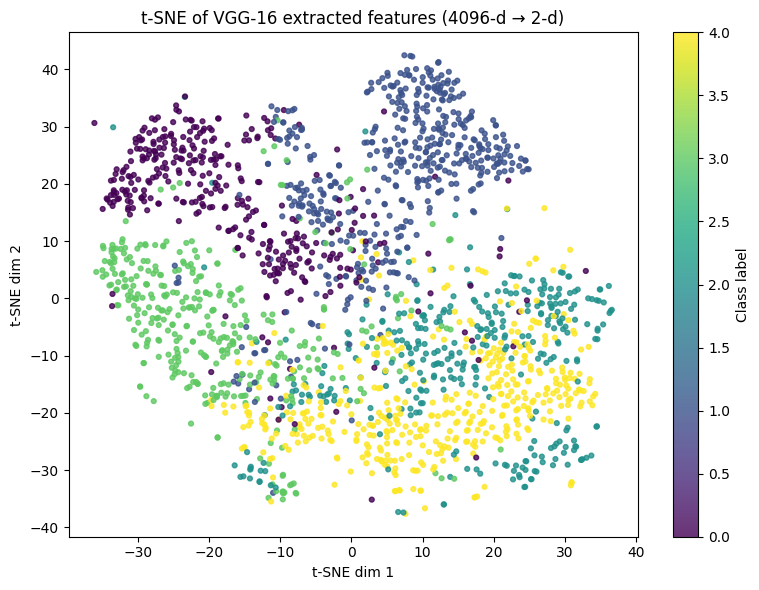

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

file = np.load("./flowers_features_and_labels.npz")
f_all = file["f_all"]
y_all = file["y_all"].astype(int)

print("f_all:", f_all.shape, "y_all:", y_all.shape)

np.random.seed(42)
N = f_all.shape[0]
max_points = 2000
idx = np.random.choice(N, size=min(max_points, N), replace=False)
X = f_all[idx]
y = y_all[idx]

X = StandardScaler().fit_transform(X)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
Z = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
sc = plt.scatter(Z[:, 0], Z[:, 1], c=y, s=12, alpha=0.8)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.title("t-SNE of VGG-16 extracted features (4096-d → 2-d)")
cbar = plt.colorbar(sc)
cbar.set_label("Class label")
plt.tight_layout()
plt.show()


From the t-SNE plot, the VGG features form noticeable clusters that roughly correspond to different flower classes, showing that the features capture meaningful visual differences. Some clusters are clearly separated in the 2D space, indicating that certain classes are easy to distinguish. However, there is also overlap in the middle area where points from different classes mix together, suggesting that some flowers look similar in color or shape. Overall, the plot shows that VGG features contain useful class information but are not perfectly separable, so a supervised model is still helpful for achieving the best classification performance

## Q18

In [5]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()

                output = self(X_)
                loss = criterion(output, X_)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [6]:
import numpy as np
import pandas as pd

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

import umap
import hdbscan


HDBSCAN_MIN_CLUSTER_SIZE_GRID = [5, 10, 20]
HDBSCAN_MIN_SAMPLES_GRID = [None, 5, 10]

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def run_kmeans(Z, k=5):
    model = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    pred = model.fit_predict(Z)
    return pred

def run_agglo(Z, n_clusters=5):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    pred = model.fit_predict(Z)
    return pred

def run_hdbscan_grid(Z, y_true):

    best = {
        "ari": -1.0,
        "min_cluster_size": None,
        "min_samples": None,
        "n_clusters_found": None,
        "noise_frac": None,
        "labels": None
    }

    for mcs in HDBSCAN_MIN_CLUSTER_SIZE_GRID:
        for ms in HDBSCAN_MIN_SAMPLES_GRID:
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms
            )
            labels = clusterer.fit_predict(Z)

            ari = adjusted_rand_score(y_true, labels)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_frac = float(np.mean(labels == -1))

            if ari > best["ari"]:
                best.update({
                    "ari": float(ari),
                    "min_cluster_size": mcs,
                    "min_samples": ms,
                    "n_clusters_found": int(n_clusters),
                    "noise_frac": noise_frac,
                    "labels": labels
                })

    return best

def ensure_numpy(X):
    if hasattr(X, "toarray"):
        return X.toarray()
    return np.asarray(X)

reducers = {}

# None
reducers["None"] = ensure_numpy(f_all)

svd = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    TruncatedSVD(n_components=50, random_state=RANDOM_STATE)
)
reducers["SVD(r=50)"] = svd.fit_transform(ensure_numpy(f_all))

um = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    umap.UMAP(
        n_components=50,
        random_state=RANDOM_STATE,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean"
    )
)
reducers["UMAP(n=50)"] = um.fit_transform(ensure_numpy(f_all))


try:
    Z_ae = Autoencoder(50).fit_transform(ensure_numpy(f_all))
    reducers["Autoencoder(f=50)"] = Z_ae
except Exception as e:
    print("[WARN] Autoencoder failed (likely input dim != 4096 or no CUDA). Error:")
    print(e)

rows = []

for red_name, Z in reducers.items():
    Z = ensure_numpy(Z)

    # KMeans
    pred_km = run_kmeans(Z, k=5)
    ari_km = adjusted_rand_score(y_all, pred_km)
    rows.append({
        "DimRed": red_name,
        "Clustering": "KMeans",
        "Hyperparameters": "k=5",
        "ARI": float(ari_km)
    })

    # Agglomerative
    pred_ag = run_agglo(Z, n_clusters=5)
    ari_ag = adjusted_rand_score(y_all, pred_ag)
    rows.append({
        "DimRed": red_name,
        "Clustering": "Agglomerative",
        "Hyperparameters": "n_clusters=5",
        "ARI": float(ari_ag)
    })

    # HDBSCAN grid search
    best_hdb = run_hdbscan_grid(Z, y_all)
    rows.append({
        "DimRed": red_name,
        "Clustering": "HDBSCAN",
        "Hyperparameters": f"min_cluster_size={best_hdb['min_cluster_size']}, min_samples={best_hdb['min_samples']}, "
                           f"clusters_found={best_hdb['n_clusters_found']}, noise_frac={best_hdb['noise_frac']:.3f}",
        "ARI": float(best_hdb["ari"])
    })

df = pd.DataFrame(rows).sort_values("ARI", ascending=False).reset_index(drop=True)

print("=== All results (sorted by ARI desc) ===")
display(df)

best_row = df.iloc[0]
print("\n=== BEST RESULT ===")
print(best_row.to_dict())


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


=== All results (sorted by ARI desc) ===


,DimRed,Clustering,Hyperparameters,ARI
0,UMAP(n=50),KMeans,k=5,0.418576
1,UMAP(n=50),Agglomerative,n_clusters=5,0.366950
2,Autoencoder(f=50),KMeans,k=5,0.242802
3,UMAP(n=50),HDBSCAN,"min_cluster_size=20, min_samples=None, cluster...",0.227520
4,SVD(r=50),Agglomerative,n_clusters=5,0.222730
5,Autoencoder(f=50),Agglomerative,n_clusters=5,0.220893
6,None,Agglomerative,n_clusters=5,0.218450
7,SVD(r=50),KMeans,k=5,0.191255
8,None,KMeans,k=5,0.189198
9,None,HDBSCAN,"min_cluster_size=5, min_samples=None, clusters...",0.006676



=== BEST RESULT ===
{'DimRed': 'UMAP(n=50)', 'Clustering': 'KMeans', 'Hyperparameters': 'k=5', 'ARI': 0.41857617946991876}


In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()

    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                # forward
                log_probs = self.forward(X_)
                loss = criterion(log_probs, y_)

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        self.model.eval()
        with torch.no_grad():
            log_probs = self.forward(X_test)
            pred = torch.argmax(log_probs, dim=1)
            acc = (pred == y_test).float().mean().item()
        return acc, pred.cpu().numpy()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import umap

X_train, X_test, y_train, y_test = train_test_split(
    f_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

mlp_orig = MLP(num_features=X_train.shape[1]).train(X_train, y_train)
acc_orig, pred_orig = mlp_orig.eval(X_test, y_test)
print("Test accuracy (Original VGG 4096D):", acc_orig)

reducer = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    umap.UMAP(n_components=50, random_state=42, n_neighbors=15, min_dist=0.1)
)

Z_train = reducer.fit_transform(X_train)
Z_test  = reducer.transform(X_test)

mlp_red = MLP(num_features=Z_train.shape[1]).train(Z_train, y_train)
acc_red, pred_red = mlp_red.eval(Z_test, y_test)
print("Test accuracy (Reduced features 50D):", acc_red)


100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


Test accuracy (Original VGG 4096D): 0.9032697677612305


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 100/100 [00:06<00:00, 16.48it/s]

Test accuracy (Reduced features 50D): 0.8174386620521545


Test accuracy (Original VGG 4096D): 0.9032697677612305

Test accuracy (Reduced features 50D): 0.8174386620521545

This indicates that the model’s performance does suffer after dimensionality reduction. However, the drop is moderate rather than drastic, suggesting that the lower-dimensional representation still retains a substantial amount of class-relevant information.

The classification results are consistent with the clustering findings in Question 18. Clustering may not perfectly separate the classes because it does not use labels. However, the relatively high classification accuracy shows that the VGG features even after dimensionality reduction still contain useful information for distinguishing classes. This makes sense because supervised models use labels to learn clearer boundaries, while clustering does not.